# Example 3B - Training of virtual staining of brightfield images (20x)

Example code to train a neural network to virtually stain brightfield images captured with the 20x magnification objective obtaining the corresponding images for nuclei, lipids and cytoplasm.

This code can be easily adapted to train other virtual staining neural networks by changing the neural network and training parameters in section 1.1 and 

version 1.0 <br />
15 November 2020 <br />
Benjamin Midtvedt, Jesús Pineda Castro, Saga Helgadottir, Daniel Midtvedt & Giovanni Volpe <br />
Soft Matter Lab @ GU <br />
http://www.softmatterlab.org

## 0. Imports
 
Import all necessary packages. These include standard Python packages as well as the core of DeepTrack 2.0 (`deeptrack`) and some specialized classes for this virtual staining (`apido`).

In [1]:
import os
import glob
import random
import itertools
from timeit import default_timer as timer

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# DeepTrack 2.0 code
import apido
from apido import deeptrack as dt

## 1. Define input and output

Set constants to determine the input and output images

### 1.1 Neural-network model parameters

Parameters of the neural network model. These are:

* `GENERATOR_BREADTH`: determines the width of the input image as `GENERATOR_BREADTH * 32` (e.g., `GENERATOR_BREADTH = 32` corresponds to an input image size `532`)

* `GENERATOR_DEPTH`: Depth of the generator U-Net

* `DISCRIMINATOR_DEPTH`: Depth of the discriminator convolutional encoder

* `MAE_LOSS_WEIGHT`: the weighting of the MAE loss vs. the adversarial loss

In [2]:
GENERATOR_BREADTH = 32
GENERATOR_DEPTH = 5
DISCRIMINATOR_DEPTH = 5
MAE_LOSS_WEIGHT = 0.001
EPOCHS = 50

### 1.2 User-defined constants for loading data and saving model

Constants defined by the user:

* `DATASET_PATH`: Input path (not including the magnification folder)

* `OUTPUT_PATH`: Output path (not including the magnication folder)

In [3]:
DATASET_PATH = "../astra_data_readonly/" 
OUTPUT_PATH = "./models/"

VALIDATION_WELLS_AND_SITES = [
    ("B04", 1),
    ("D03", 5),
    ("B04", 2),
    ("C04", 2),
    ("C03", 5),
    ("D02", 5),
    ("C02", 1),
    ("C04", 3),
]

### 1.3 Inferred constants

Constants inferred from the user input

In [4]:
MAGNIFICATION = "20x"
file_name_struct = "AssayPlate_Greiner_#655090_{0}_T0001F{1}L01A0{2}Z0{3}C0{2}.tif"

PATH_TO_OUTPUT = os.path.normpath(OUTPUT_PATH)

Infer full path to dataset

In [5]:
_glob_struct = os.path.join(DATASET_PATH, MAGNIFICATION + "*/")
_glob_results = glob.glob(_glob_struct)

if len(_glob_results) == 0:
    raise ValueError("No path found matching glob {0}".format(_glob_struct))
elif len(_glob_results) > 1:
    from warnings import warn
    warn("Multiple paths found! Using {0}".format(_glob_results[0]))

PATH_TO_MAGNIFICATION = os.path.normpath(_glob_results[0])

In [6]:
print("Loading images from: \t", PATH_TO_MAGNIFICATION)
print("Saving results to: \t", PATH_TO_OUTPUT)

Loading images from: 	 ../astra_data_readonly/20x_images
Saving results to: 	 models


## 2. Load train data

We define a data pipeline for loading images from storage. This uses DeepTrack 2.0, and follows the structure of

1. Load each z-slice of a well-site combination and concatenate them.
2. Pad the volume such that the first two dimensions are multiples of 32 (required by the model).
3. Correct for misalignment of the fluorescence channel and the brightfield channel (by a pre-calculated parametrization of the offset as a function of magnification and the site).

### 2.1 Find all wells and sites

We create an iterator over each well and site. `itertools.product` produces an iterator over each combination of its input. In this case, each site in each well.

In [7]:
wells_and_sites = list(
    itertools.product(
        ["B03", "B04", "C02", "C03", "C04", "D02", "D03", "D04"],
        range(1, 7) 
    )
)

In [8]:
random.seed(1)
random.shuffle(wells_and_sites)

training_set = [w_s_tuple for w_s_tuple in wells_and_sites if w_s_tuple not in VALIDATION_WELLS_AND_SITES]
validation_set = VALIDATION_WELLS_AND_SITES

print("Training on {0} images".format(len(training_set)))
print("Validating on {0} images".format(len(validation_set)))

Training on 40 images
Validating on 8 images


### 2.2 The root feature

We use DeepTrack 2.0 to define the data loader pipeline. The pipeline is a sequence of `features`, which perform computations, controlled by `properties`, which are defined when creating the features. (Note that we any property with any name and value to a feature; if a property is not used by the feature, we refer to it as a dummy property.)

The feature `root` is a `DummyFeature`, which is just a container of dummy properties and does not perform any computations.
It takes the following arguments:

* `well_site_tuple` is a dummy property that cycles through the well-site combinations in `wells_and_sites`
* `well` is a dummy property that extracts the well from the `well_site_tuple`
* `site` is a dummy property that extracts the site from the `well_site_tuple`

Note that `well` and `site` are functions that take `well_site_tuple` as argument. These are dependent properties, and DeepTrack 2.0 will automatically ensure that they receive the correct input.

In [9]:
training_iterator = itertools.cycle(training_set)
validation_iterator = itertools.cycle(validation_set)

def get_next_well_and_site(validation):
    if validation:
        return next(validation_iterator)
    else:
        return next(training_iterator)

# Accepts a tuple of form (well, site), and returns the well
def get_well_from_tuple(well_site_tuple):
    return well_site_tuple[0]

# Accepts a tuple of form (well, site), and returns the site as 
# a string formated to be of length 3.
def get_site_from_tuple(well_site_tuple):
    site_string = "00" + str(well_site_tuple[1])
    return site_string[-3:]



root = dt.DummyFeature(
    well_site_tuple=get_next_well_and_site,           # On each update, root will grab the next value from this iterator
    well=get_well_from_tuple,                         # Grabs the well from the well_site_tuple
    site=get_site_from_tuple,                         # Grabs and formats the site from the well_site_tuple
)

### 2.3 The brightfield image loader

We use `deeptrack.LoadImage` to load and concatenate a brightfield stack. It takes the following arguments:

* `**root.properties` means that we take the properties of `root` (of importance `well` and `site`). The other properties of LoadImage will now depend on these.
* `file_names` is a dummy property, which takes the current well and site as input, and creates a list of file names that we want to load.
* `path` is a property used by `LoadImage` to determine which files to load. We calculate it by taking `file_names` as input and returning a list of paths using `os.path.join`.

Since `path` is a list, `LoadImage` stacks the images along the last dimension, creating a shaped volume with dimensions (width, height, 7).

In [10]:
brightfield_loader = dt.LoadImage(
    **root.properties,
    file_names=lambda well, site: [file_name_struct.format(well, site, 4, z) for z in range(1, 8)],
    path=lambda file_names: [os.path.join(PATH_TO_MAGNIFICATION, file_name) for file_name in file_names],
)

### 2.4 The fluorescence image loader

We use `deeptrack.LoadImage` to load and concatenate a fluorescence stack. It takes the following arguments:

* `**root.properties` means that we take the properties of `root` (of importance `well` and `site`). The other properties of LoadImage will now depend on these.
* `file_names` is a dummy property, which takes the current well and site as input, and creates a list of file names that we want to load.
* `path` is a property used by `LoadImage` to determine which files to load. We calculate it by taking `file_names` as input and returning a list of paths using `os.path.join`.

Since `path` is a list, `LoadImage` stacks the images along the last dimension, creating a shaped volume with dimensions (width, height, 3).

In [11]:
fluorescence_loader = dt.LoadImage(
    **root.properties,
    file_names=lambda well, site: [file_name_struct.format(well, site, action, 1) for action in range(1, 4)],
    path=lambda file_names: [os.path.join(PATH_TO_MAGNIFICATION, file_name) for file_name in file_names],
)

### 2.5 Offset adjustment

Offset adjustments using affine transformations. The offset is parametrized as a function of the magnification and the site as described in the report.

The properties are set as follows:
* `translate` sets how much we translate the image in pixels. It is a tuple representing the (x, y) shift. We calculate it as a function of the angular position of the site within the well, with site 1 at angle 0.
* `angle` is a dummy property that calculates the angle of the site in radians.

In [12]:
# Coefficients of the regression
Ax = 3.9549
Bx = 0.06653
x = -1.22169
Ay = -0.1979
By = -4.0921
y = 0.7653
scale = 0.9988

correct_offset = dt.Affine(
    translate=lambda angle: (
        (np.cos(angle) * Bx + np.sin(angle) * Ax + x) * -1, # Offset in x
        (np.cos(angle) * By + np.sin(angle) * Ay + y) * -1, # Offset in y
    ),
    angle = lambda site: (int(site) - 1) * np.pi / 6,
    scale=scale,
    **root.properties,
)

### 2.6 Define augmentations

We use three kinds of augmentations: Mirroring (`deeptrack.FlipLR`), Affine transformations (`deeptrack.ElasticTransformation`), and Distortions (`deeptrack.Crop`)

In [13]:
flip = dt.FlipLR()

affine = dt.Affine(
    rotate=lambda: np.random.rand() * 2 * np.pi,
    scale=lambda: np.random.rand() * 0.1 + 0.95,
    shear=lambda: np.random.rand() * 0.05 - 0.025
)

distortion = dt.ElasticTransformation(
    alpha=lambda: np.random.rand() * 80,
    sigma=lambda: 7
)

corner = int(512 * (np.sqrt(2) - 1) / 2)
cropping  = dt.Crop(
    crop=(512, 512, None),
    corner=(corner, corner, 0)
)

### 2.7 Create the pipeline 

We use the (`+`) operator to chain the features, defining the execution order. In DeepTrack 2.0, this means that the output of the feature on the left, is passed as the input to the feature on the right. This is done in the following steps:

1. `corrected_brightfield` is generated by offsetting the `brightfield_loader`
2. `data_pair` is created with input images and targets
3. `augmented_data` are defined by using the augmentations as well as the cropping
4. `validation_data` is created
5. `dataset` is created

In [14]:
corrected_brightfield = brightfield_loader + correct_offset

data_pair = dt.Combine([corrected_brightfield, fluorescence_loader])

padded_crop_size = int(512 * np.sqrt(2))

cropped_data = dt.Crop(
    data_pair,
    crop=(padded_crop_size, padded_crop_size, None),
    updates_per_reload=16,
    corner=lambda: (*np.random.randint(0, 5000, size=2), 0),
)

augmented_data = cropped_data + flip + affine + distortion + cropping

validation_data = data_pair + dt.PadToMultiplesOf(multiple=(32, 32, None))

dataset = dt.ConditionalSetFeature(
    on_true=validation_data,
    on_false=augmented_data,
    condition="is_validation",
    is_validation=lambda validation: validation
) + dt.AsType("float64")

## 3. Define generator

We use generators to interface DeepTrack 2.0 features with Keras training routines. In DeepTrack 2.0, we have defined some special generators that speed up training. Here, we will use `deeptrack.ContinuousGenerator`, which continuosly geenrate augmented training images and makes them available for training the neural network model.

In [15]:
generator = dt.generators.ContinuousGenerator(
    dataset,
    batch_function=lambda image: image[0],
    label_function=lambda image: image[1],
    batch_size=8,
    min_data_size=100,
    max_data_size=2000
)

## 4. Define model

Here, we use a GAN with a U-Net generator and a convolutional encoder discriminator. The generator is trained on MSE of the GAN error and MAE of the pixel difference. The discriminator is trained using MSE loss.

More details are provided in the report.

We also compile the assembled GAN with metrics, which include feature-wise MAE.

In [16]:
GAN_generator = apido.generator(GENERATOR_BREADTH, GENERATOR_DEPTH)
GAN_generator.summary()
GAN_discriminator = apido.discriminator(DISCRIMINATOR_DEPTH)
GAN_discriminator.summary()

GAN = dt.models.cgan(
    generator=GAN_generator,
    discriminator=GAN_discriminator,
    discriminator_loss="mse",
    discriminator_optimizer=Adam(lr=0.0002, beta_1=0.5),
    assemble_loss=["mse", "mae"],
    assemble_optimizer=Adam(lr=0.0002, beta_1=0.5),
    assemble_loss_weights=[
        1- MAE_LOSS_WEIGHT,
        MAE_LOSS_WEIGHT
    ],
)

GAN.compile(loss="mae", metrics=apido.metrics("20x"))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 7 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 2048        lambda[0][0]                     
__________________________________________________________________________________________________
instance_normalization (Instanc (None, None, None, 3 64          conv2d[0][0]                     
_______________________________________________________________________________________

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, None, None, 1 0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 1 0           concatenate_4[0][0]   

## 5. Train model

We execute the dataset pipeline, setting the option `validation` to be True in the update step. This toggles the ConditionalSetFeature to skip the augmentation, as well as making `root` draw the site-tuple from the validation set.

Following this we initialize the generator using the `with` statements, which launches a thread to generate `min_data_size` samples before starting training. Finally `fit` starts the training.

In [20]:
validation_inputs = []
validation_targets = []

for _ in range(len(validation_set)):
    data_tuple = dataset.update(validation=True).resolve()
    validation_inputs.append(data_tuple[0])
    validation_targets.append(data_tuple[1])


with generator:
    h = GAN.fit(
        generator, 
        epochs=200,
        validation_data=(
            np.array(validation_inputs),
            np.array(validation_targets)
        ),
        validation_batch_size=4
    )

Generating 439 / 100 samples before starting training
Epoch 1/200
54/54 [==============================] - 24s 443ms/step - d_loss: 0.4430 - g_loss: 0.3270 - nuclei: 0.8194 - lipids: 0.4104 - cyto: 0.2405 - val_loss: 206.1285 - val_nuclei: 0.8111 - val_lipids: 0.4020 - val_cyto: 0.2569
Epoch 2/200
54/54 [==============================] - 23s 426ms/step - d_loss: 0.4366 - g_loss: 0.3204 - nuclei: 0.8077 - lipids: 0.4018 - cyto: 0.2381 - val_loss: 207.1642 - val_nuclei: 0.8185 - val_lipids: 0.3920 - val_cyto: 0.2680
Epoch 3/200
54/54 [==============================] - 23s 422ms/step - d_loss: 0.4321 - g_loss: 0.3153 - nuclei: 0.7995 - lipids: 0.3938 - cyto: 0.2377 - val_loss: 200.5750 - val_nuclei: 0.8015 - val_lipids: 0.3852 - val_cyto: 0.2504
Epoch 4/200
54/54 [==============================] - 23s 421ms/step - d_loss: 0.4240 - g_loss: 0.3126 - nuclei: 0.7984 - lipids: 0.4059 - cyto: 0.2375 - val_loss: 202.4858 - val_nuclei: 0.7915 - val_lipids: 0.3904 - val_cyto: 0.2586
Epoch 5/200
54

54/54 [==============================] - 23s 423ms/step - d_loss: 0.3738 - g_loss: 0.2528 - nuclei: 0.6441 - lipids: 0.3581 - cyto: 0.2178 - val_loss: 184.8292 - val_nuclei: 0.7055 - val_lipids: 0.3556 - val_cyto: 0.2439
Epoch 35/200
54/54 [==============================] - 23s 425ms/step - d_loss: 0.3738 - g_loss: 0.2522 - nuclei: 0.6400 - lipids: 0.3600 - cyto: 0.2157 - val_loss: 184.1545 - val_nuclei: 0.7214 - val_lipids: 0.3520 - val_cyto: 0.2375
Epoch 36/200
54/54 [==============================] - 23s 420ms/step - d_loss: 0.3761 - g_loss: 0.2520 - nuclei: 0.6332 - lipids: 0.3554 - cyto: 0.2155 - val_loss: 186.0668 - val_nuclei: 0.7161 - val_lipids: 0.3553 - val_cyto: 0.2455
Epoch 37/200
54/54 [==============================] - 24s 436ms/step - d_loss: 0.3722 - g_loss: 0.2476 - nuclei: 0.6276 - lipids: 0.3497 - cyto: 0.2142 - val_loss: 183.2191 - val_nuclei: 0.7019 - val_lipids: 0.3557 - val_cyto: 0.2377
Epoch 38/200
54/54 [==============================] - 23s 419ms/step - d_loss

KeyboardInterrupt: 

## 7. Visualize validation set

We plot and show model predictions for each image in the validation set

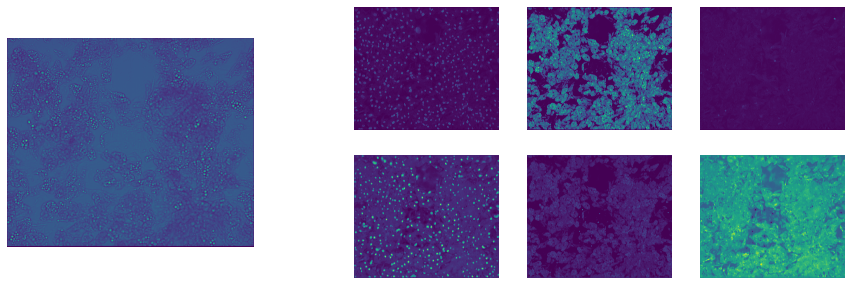

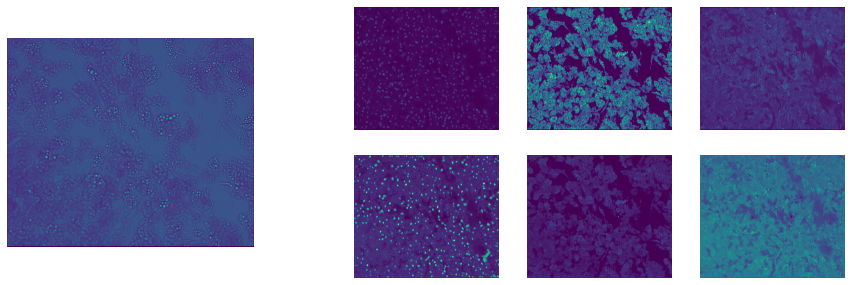

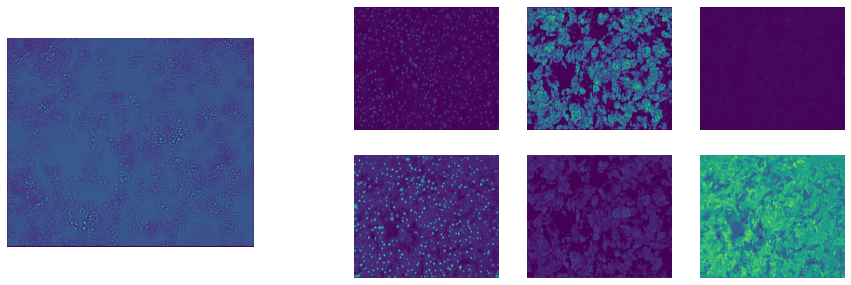

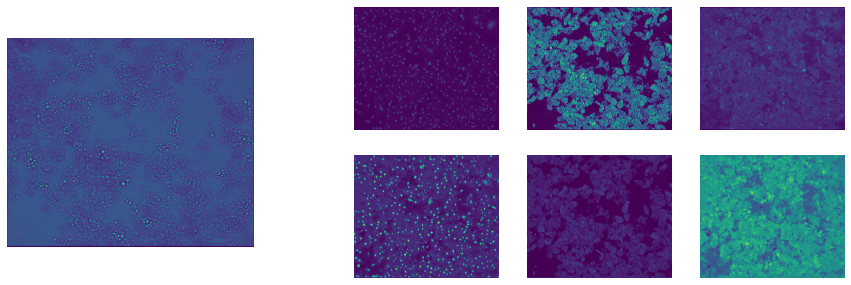

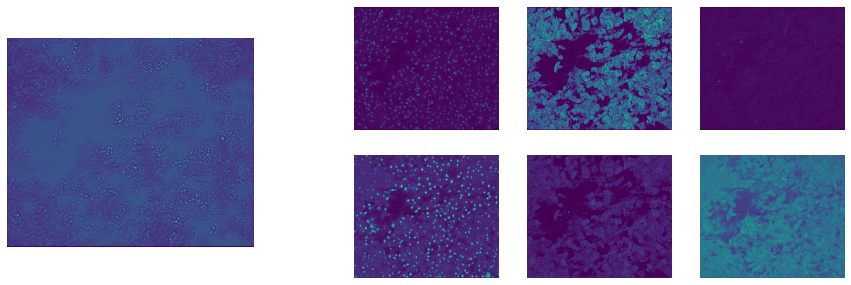

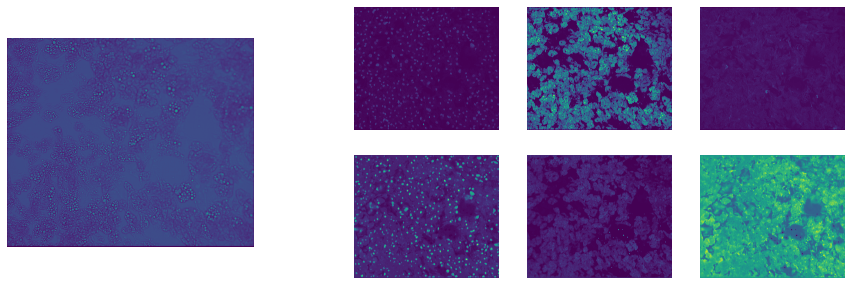

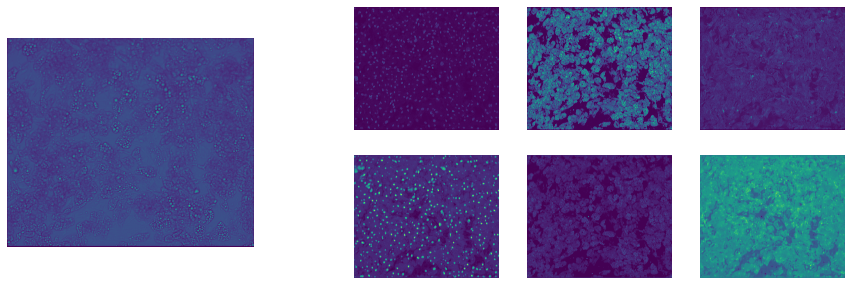

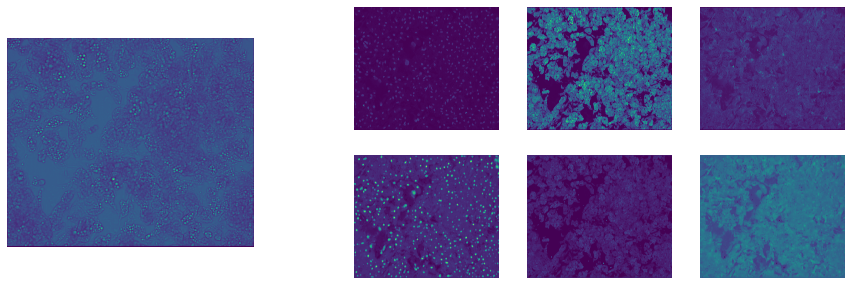

In [21]:
prediction = GAN.generator.predict(np.array(validation_inputs), batch_size=4)

for brightfield, targets, prediction in zip(validation_inputs, validation_targets, prediction):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(brightfield[:, :, 0])
    plt.axis("off")
    
    plt.subplot(2,5,3)
    plt.imshow(targets[:, :, 0])
    plt.axis("off")
    plt.subplot(2,5,4)
    plt.imshow(targets[:, :, 1])
    plt.axis("off")
    plt.subplot(2,5,5)
    plt.imshow(targets[:, :, 2])
    plt.axis("off")
    
    plt.subplot(2,5,8)
    plt.imshow(prediction[:, :, 0])
    plt.axis("off")
    plt.subplot(2,5,9)
    plt.imshow(prediction[:, :, 1])
    plt.axis("off")
    plt.subplot(2,5,10)
    plt.imshow(prediction[:, :, 2])
    plt.axis("off")
    plt.show()

## 7. Save model

We save the generator and the discriminator seperately. The folder is named after the current date, the user which is running the notebook, and the current magnification.

In [19]:
folder_name = apido.get_checkpoint_name("60x")

# Save generator
generator_checkpoint_path = os.path.join(PATH_TO_OUTPUT, folder_name, "generator_checkpoint")
os.makedirs(generator_checkpoint_path, exist_ok=True)
GAN.generator.save(generator_checkpoint_path)

# Save discriminator
discriminator_checkpoint_path = os.path.join(PATH_TO_OUTPUT, folder_name, "discriminator_checkpoint")
os.makedirs(discriminator_checkpoint_path, exist_ok=True)
GAN.discriminator.save(discriminator_checkpoint_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/root_15-11-2020T051318_model_60x/generator_checkpoint/assets
INFO:tensorflow:Assets written to: models/root_15-11-2020T051318_model_60x/discriminator_checkpoint/assets
